# Descriptions
- BERT stands for Bidirectional Encoder Representations from Transformers
- BERT was developed by researchers at Google in 2018
- BERT is a text representation technique like Word Embeddings.

Hackathon: Identify the sentiments
- https://datahack.analyticsvidhya.com/contest/all/

# Google Colab

In [1]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install bert-for-tf2
    !pip install sentencepiece
    !pip install neptune-client neptune-contrib
    !pip install scikit-plot

    ## print
    print('Environment: Google Colaboratory.')

# NOTE: If we update modules in gcolab, we need to restart runtime.

In [2]:
import neptune
from neptunecontrib.api import log_table

In [8]:
# use your real key and DELETE the cell

# neptune.init('bhishanpdl/twitter-sentiment-analysis','your_api_key')

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras import layers
import bert

from pprint import pprint
versions = [(x.__name__,x.__version__) for x in [tf, hub, keras,bert]]
pprint(versions)

[('tensorflow', '2.3.0'),
 ('tensorflow_hub', '0.9.0'),
 ('keras', '2.4.3'),
 ('bert', '0.14.6')]


In [10]:
versions_dl = str(versions)
versions_dl

"[('tensorflow', '2.3.0'), ('tensorflow_hub', '0.9.0'), ('keras', '2.4.3'), ('bert', '0.14.6')]"

In [11]:
neptune.create_experiment(
    name='bert_tf2', # put small name
    description='',
    tags = ['bert', 'tf2'],
    upload_source_files=None
)

neptune.append_tags(['bertFull'])

https://ui.neptune.ai/bhishanpdl/twitter-sentiment-analysis/e/TWITSENT-10


In [12]:
neptune.log_text('versions_dl', versions_dl)

# Load the libraries

In [13]:
import numpy as np
import pandas as pd
from pprint import pprint

pd.set_option('max_colwidth',200)
pd.set_option('max_columns',200)
SEED = 100

import sys
import re
from tqdm import tqdm
tqdm.pandas()

versions_ds = [(x.__name__,x.__version__) for x in [np,pd]]
pprint(versions_ds)

[('numpy', '1.18.5'), ('pandas', '1.0.5')]


In [14]:
neptune.log_text('versions_ds', str(versions_ds))

# Load the data

In [15]:
p = 'https://github.com/bhishanpdl/Datasets/blob/master/AV_Hackathons/sentiment_analysis/raw/'
df_train = pd.read_csv(p + 'train.csv?raw=true')
df_test = pd.read_csv(p + 'test.csv?raw=true')

print(f"train : {df_train.shape}")
print(f"test : {df_test.shape}")

display(df_train.head(2).append(df_train.tail(2)))

target = 'label'
maincol = 'tweet'

train : (7920, 3)
test : (1953, 2)


,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
7918,7919,0,"Finally got my #smart #pocket #wifi stay connected anytime,anywhere! #ipad and #samsung #s3 #gadget # http://instagr.am/p/U-53G_vJU8/"
7919,7920,0,Apple Barcelona!!! #Apple #Store #BCN #Barcelona #travel #iphone #selfie #fly #fun #cabincrew… http://instagram.com/p/wBApVzpCl3/


In [16]:
neptune.log_text('data_path',p)

# Text Data Processing

In [17]:
maincol = 'tweet'
target = 'label'
mc = maincol + '_clean'
tmc = 'tokenized_' + mc

In [18]:
import re
def process_text(text):
    out = re.sub(r'<[^>]+>','', text) # remove html tags
    out = re.sub('[^a-zA-Z]', ' ', out) # keep only alpha
    out = re.sub(r"\s+[a-zA-Z]\s+", ' ', out) # remove single letter
    out = re.sub(r'\s+', ' ', out) # remove multiple spaces

    return out

In [19]:
str_proc = 'remove: html singleLetter multipleSpaces keep: onlyAlphabet'
neptune.log_text('text processing', str_proc)

In [20]:
df_train[mc] = df_train[maincol].progress_apply(process_text)
df_test[mc] = df_test[maincol].progress_apply(process_text)

100%|██████████| 1953/1953 [00:00<00:00, 46882.64it/s]


In [21]:
df_train.head(2)

,id,label,tweet,tweet_clean
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint Pregnancy Test https goo gl MfQV android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,Finally transparant silicon case Thanks to my uncle yay Sony Xperia sonyexperias http instagram com YGEt JC JM


In [22]:
X_train = df_train[mc].to_list()
y_train = df_train[target].to_list()

X_test = df_test[mc].to_list()
y_test = None # does not exist

# Tokenizing

In [23]:
%%time
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

CPU times: user 5.92 s, sys: 1.06 s, total: 6.98 s
Wall time: 6.88 s


In [24]:
tokenizer.tokenize("nlp is fun.")

['nl', '##p', 'is', 'fun', '.']

In [25]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("nlp is fun."))

[17953, 2361, 2003, 4569, 1012]

In [26]:
def encode_sentence(sentence):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))

In [27]:
df_train[tmc] = df_train[mc].progress_apply(encode_sentence)
df_test[tmc] = df_test[mc].progress_apply(encode_sentence)

100%|██████████| 1953/1953 [00:00<00:00, 3222.10it/s]


In [28]:
# shuffle the data
df_train = df_train.sample(frac=1,random_state=SEED)

In [29]:
df_train['length'] = df_train[mc].progress_apply(len)

100%|██████████| 1953/1953 [00:00<00:00, 668364.53it/s]


In [30]:
df_train.head(2)

,id,label,tweet,tweet_clean,tokenized_tweet_clean,length
2144,2145,0,Is My Birthday #1año #cat #cateyes #glasses #cool #baby #sony #ilovemycat https://instagram.com/p/zx_hV6lrYI/,Is My Birthday o cat cateyes glasses cool baby sony ilovemycat https instagram com zx hV lrYI,"[2003, 2026, 5798, 1051, 4937, 4937, 17683, 2015, 7877, 4658, 3336, 8412, 6335, 21818, 8029, 11266, 16770, 16021, 23091, 4012, 1062, 2595, 1044, 2615, 1048, 2854, 2072]",94
5076,5077,0,Fun time with my babies! Thank you Aunty stylistikafadje for the photo! #apple #iphone … http://instagram.com/p/lERwawFmoJ/,Fun time with my babies Thank you Aunty stylistikafadje for the photo apple iphone http instagram com lERwawFmoJ,"[4569, 2051, 2007, 2026, 10834, 4067, 2017, 5916, 2100, 2358, 8516, 2923, 7556, 7011, 2094, 6460, 2005, 1996, 6302, 6207, 18059, 8299, 16021, 23091, 4012, 3393, 2099, 4213, 2860, 16715, 29147]",113


In [31]:
# sort data with length
df_train = df_train.sort_values('length')
df_train.head(2)

,id,label,tweet,tweet_clean,tokenized_tweet_clean,length
6340,6341,0,#ERROR!,ERROR,[7561],7
4451,4452,1,alrdy at 65%. I had 100% an hour & a half ago! iphone,alrdy at had an hour half ago iphone,"[2632, 17460, 2012, 2018, 2019, 3178, 2431, 3283, 18059]",36


In [32]:
sorted_data_labels = [ (df_train[tmc][i], df_train[target][i]) for i in range(len(df_train)) ]

In [33]:
sorted_data_labels[0][0][:5]

[4344, 16550, 10032, 3231, 16770]

In [34]:
# pad each batch (better than padding whole dataset)
sorted_data_labels = [ (df_train[tmc][i], df_train[target][i]) for i in range(len(df_train)) ]

BATCH_SIZE = 32

processed_train_dataset = \
tf.data.Dataset.from_generator(
    lambda: sorted_data_labels,
     output_types=(tf.int32, tf.int32)
     )

batched_train_dataset = processed_train_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [36]:
neptune.log_metric('batch',BATCH_SIZE)

In [37]:
# see the first batch
# next(iter(batched_dataset))

# Train Validation Split

In [38]:
TOTAL_BATCHES = np.ceil(len(sorted_data_labels) / BATCH_SIZE)
VALID_BATCHES = TOTAL_BATCHES // 10

batched_train_dataset.shuffle(TOTAL_BATCHES,seed=SEED)

valid_data = batched_train_dataset.take(VALID_BATCHES)
train_data = batched_train_dataset.skip(VALID_BATCHES)

In [39]:
type(valid_data)

tensorflow.python.data.ops.dataset_ops.TakeDataset

# Create the model

In [40]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)

        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")

        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)

        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        concatenated = tf.concat([self.pool(self.cnn_layer(l))]*4, axis=-1) # (batch_size, N * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)

        return model_output

neptune.log_text('num_cnn_layers', '4')

In [41]:
# Hyperparameters
VOCAB_LENGTH = len(tokenizer.vocab)
OUTPUT_CLASSES = 2

PARAMS = dict()
PARAMS['EMB_DIM'] = 200
PARAMS['CNN_FILTERS'] = 100
PARAMS['DNN_UNITS'] = 256
PARAMS['OUTPUT_CLASSES'] = 2
PARAMS['DROPOUT_RATE'] = 0.1
PARAMS['NB_EPOCHS'] = 10

In [42]:
for k,v in PARAMS.items():
    neptune.log_metric(k,v)

In [43]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=PARAMS['EMB_DIM'],
                        cnn_filters=PARAMS['CNN_FILTERS'],
                        dnn_units=PARAMS['DNN_UNITS'],
                        model_output_classes=PARAMS['OUTPUT_CLASSES'],
                        dropout_rate=PARAMS['DROPOUT_RATE'])

In [44]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [45]:
%%time

# Note: use gpu 
text_model.fit(train_data, epochs=PARAMS['NB_EPOCHS'])

Epoch 1/10
224/224 [==============================] - 16s 73ms/step - loss: 0.3142 - accuracy: 0.8553
Epoch 2/10
224/224 [==============================] - 13s 59ms/step - loss: 0.1487 - accuracy: 0.9437
Epoch 3/10
224/224 [==============================] - 13s 59ms/step - loss: 0.0611 - accuracy: 0.9803
Epoch 4/10
224/224 [==============================] - 13s 58ms/step - loss: 0.0238 - accuracy: 0.9941
Epoch 5/10
224/224 [==============================] - 13s 59ms/step - loss: 0.0082 - accuracy: 0.9983
Epoch 6/10
224/224 [==============================] - 13s 59ms/step - loss: 0.0043 - accuracy: 0.9993
Epoch 7/10
224/224 [==============================] - 13s 59ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 8/10
224/224 [==============================] - 13s 58ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 9/10
224/224 [==============================] - 13s 59ms/step - loss: 0.0014 - accuracy: 0.9999
Epoch 10/10
224/224 [==============================] - 13s 58ms/step - loss: 9.738

In [46]:
valid_results = text_model.evaluate(valid_data)
print(valid_results)

24/24 [==============================] - 0s 6ms/step - loss: 0.5091 - accuracy: 0.8906
[0.509110152721405, 0.890625]


In [47]:
# true validation labels
y_valid = []
for element in valid_data.as_numpy_iterator():
  y_valid += element[1].tolist()

y_valid[:5]

[0, 0, 0, 0, 1]

In [48]:
# predicted validation labels
valid_probs = text_model.predict(valid_data)
valid_preds = [1 if i>0.5 else 0 for i in valid_probs]
valid_probs[:5], valid_preds[:5]

(array([[1.55687410e-12],
        [6.82577302e-05],
        [2.91392971e-05],
        [1.06004315e-07],
        [9.97075438e-01]], dtype=float32), [0, 0, 0, 0, 1])

In [49]:
valid_probs_2d = np.zeros(shape=(len(valid_probs),2))
valid_probs_2d[:,0] = 1 - valid_probs.ravel()
valid_probs_2d[:,1] = valid_probs.ravel()
valid_probs_2d[:5]

array([[1.00000000e+00, 1.55687410e-12],
       [9.99931753e-01, 6.82577302e-05],
       [9.99970853e-01, 2.91392971e-05],
       [9.99999881e-01, 1.06004315e-07],
       [2.92456150e-03, 9.97075438e-01]])

# Model Evaluation for Validation Data

In [50]:
from sklearn import metrics

In [51]:
df_eval = pd.DataFrame({
    'Text Model': [],
    'Params': [],
    'Model': [],
    'Description': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
})

In [52]:
text_model_name = "bert"
params = "bert_en_uncased_L-12_H-768_A-12"
model_name = "tf"
desc = "cnn layers"

yvd = y_valid
vd_preds = valid_preds

acc = metrics.accuracy_score(yvd,vd_preds)
pre = metrics.precision_score(yvd,vd_preds)
rec = metrics.recall_score(yvd,vd_preds)
f1 = metrics.f1_score(yvd,vd_preds,average='weighted')

row = [text_model_name, params, model_name,desc]
row = row + [acc, pre, rec, f1]

df_eval.loc[len(df_eval)] = row
df_eval = df_eval.drop_duplicates(subset=['Text Model', 'Params', 'Model', 'Description'])

df_eval

,Text Model,Params,Model,Description,Accuracy,Precision,Recall,F1
0,bert,bert_en_uncased_L-12_H-768_A-12,tf,cnn layers,0.890625,0.730594,0.864865,0.893585


In [53]:
from neptunecontrib.api import log_table

log_table('df_eval', df_eval)

In [54]:
dic_results = {'acc':acc,
               'precision':pre,
               'recall':rec,
               'f1': f1}

for k,v in dic_results.items():
    print('test_'+k, v)
    neptune.log_metric('test_'+k, v)

test_acc 0.890625
test_precision 0.730593607305936
test_recall 0.8648648648648649
test_f1 0.8935848559458419


# Diagnostic Charts for Validation Data

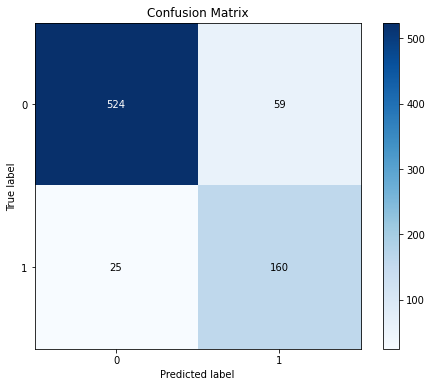

In [55]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(y_valid, valid_preds, ax=ax)
neptune.log_image('diagnostic_charts', fig)

In [56]:
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_lift_curve

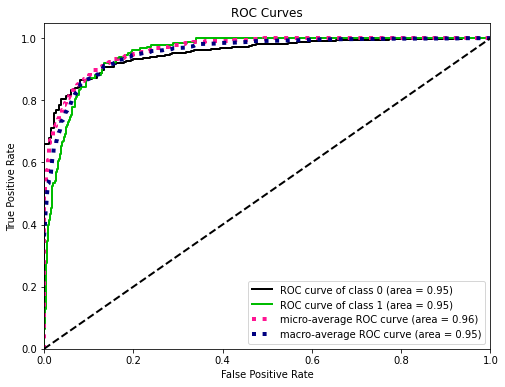

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_roc(y_valid, valid_probs_2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

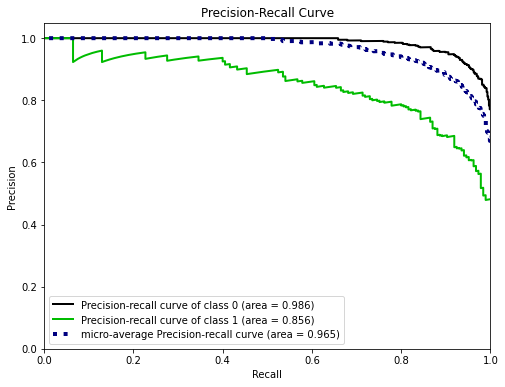

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_precision_recall(y_valid, valid_probs_2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

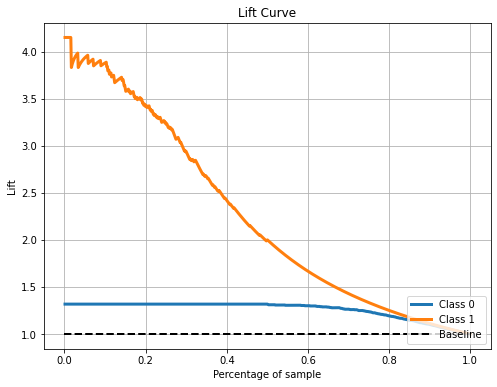

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_lift_curve(y_valid, valid_probs_2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

# Test Data Prediction

In [70]:
df_train.shape, df_test.shape

((7920, 6), (1953, 5))

In [79]:
df_test.head(2)

,id,tweet,tweet_clean,tokenized_tweet_clean,length
0,7921,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks,I hate the new iphone upgrade Won let me download apps ugh apple sucks,"[1045, 5223, 1996, 2047, 18059, 12200, 2180, 2292, 2033, 8816, 18726, 1057, 5603, 6207, 19237]",70
1,7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/,currently shitting my fucking pants apple iMac cashmoney raddest swagswagswag http instagr am UUIS bIBZo,"[2747, 4485, 3436, 2026, 8239, 6471, 6207, 10047, 6305, 5356, 8202, 3240, 10958, 14141, 4355, 25430, 26454, 4213, 5620, 4213, 2290, 8299, 16021, 15900, 2099, 2572, 1057, 27020, 12170, 2497, 6844]",105


In [82]:
df_test[tmc].apply(len).min()

8

In [83]:
tmp = [ (df_test[tmc][i], 0) for i in range(len(df_test)) ]

BATCH_SIZE = 32

processed_test_dataset = \
tf.data.Dataset.from_generator(
    lambda: tmp,
     output_types=(tf.int32, tf.int32)
     )

batched_test_dataset = processed_test_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [84]:
test_data = batched_test_dataset

In [85]:
# predicted test labels
test_probs = text_model.predict(test_data)
test_preds = [1 if i>0.5 else 0 for i in test_probs]
test_preds[:5], len(test_preds)

([1, 1, 1, 1, 1], 1953)

In [86]:
df_sub = pd.DataFrame({'id': df_test['id'],
                       'label': test_preds})

df_sub.head(2)

,id,label
0,7921,1
1,7922,1


In [87]:
df_sub.to_csv('sub_bert_tf2.csv',index=False)

In [88]:
!head -2 sub_bert_tf2.csv

id,label
7921,1


In [90]:
# upload the data to analytics vidhya

In [91]:
neptune.log_text('AV valid score:', '0.878749831788103')